Задание

Приложить файл с названием по образцу SShirkin_predictions.csv
с предсказанными ценами для квартир из test.csv (файл должен содержать два поля: Id, Price).
В файле с предсказаниями должна быть 5001 строка (шапка + 5000 предсказаний).

Примечание: при использовании статистик (среднее, медиана и т.д.) в качестве признаков,
лучше считать их на трейне, и потом на валидационных и тестовых данных не считать 
статистики заново, а брать их с трейна. Если хватает знаний, можно использовать кросс-валидацию,
но для сдачи этого проекта достаточно разбить данные из train.csv на train и valid.

In [608]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'svg'
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [609]:
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold

In [610]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(10,5)) 
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
   
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

Dataset description

* Id - идентификационный номер квартиры
* DistrictId - идентификационный номер района
* Rooms - количество комнат
* Square - площадь
* LifeSquare - жилая площадь
* KitchenSquare - площадь кухни
* Floor - этаж
* HouseFloor - количество этажей в доме
* HouseYear - год постройки дома
* Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
* Social_1, Social_2, Social_3 - социальные показатели местности
* Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
* Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
* Price - цена квартиры

In [611]:
train_df = pd.read_csv('C:\\Users\\Alisa\\Documents\\Кристина\\GigBrains\\Python for DS\\Курсовой проект\\train.csv')

train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [612]:
train_df.shape


(10000, 20)

In [613]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Не хватает данных по показателям LifeSquare 7887 и Healthcare_1 5202 их надо дозаполнить

In [614]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


In [615]:
test_df = pd.read_csv('C:\\Users\\Alisa\\Documents\\Кристина\\GigBrains\\Python for DS\\Курсовой проект\\test.csv')

test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [616]:
test_df.shape

(5000, 19)

In [617]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3959 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Ecology_2      5000 non-null   object 
 11  Ecology_3      5000 non-null   object 
 12  Social_1       5000 non-null   int64  
 13  Social_2       5000 non-null   int64  
 14  Social_3       5000 non-null   int64  
 15  Healthcare_1   2623 non-null   float64
 16  Helthcare_2    5000 non-null   int64  
 17  Shops_1        5000 non-null   int64  
 18  Shops_2 

Не хватает данных по показателям LifeSquare 3959 и Healthcare_1 2623 их надо дозаполнить

In [618]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


Чтобы 'Id' не влиял на модель сделаю его строкой

In [619]:
train_df['Id'] = train_df['Id'].astype(str)
train_df['DistrictId'] = train_df['DistrictId'].astype(str)


test_df['Id'] = test_df['Id'].astype(str)
test_df['DistrictId'] = test_df['DistrictId'].astype(str)

Целевая переменная

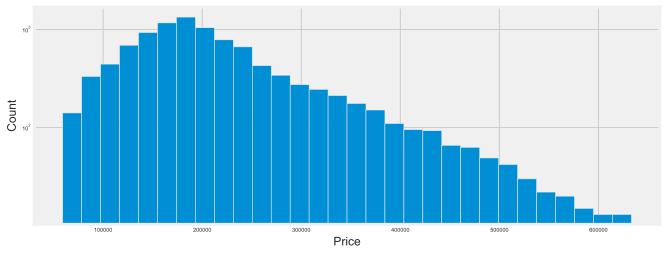

In [620]:
plt.figure(figsize = (10, 4))
train_df['Price'].hist(bins=30)
plt.yscale(value='log')
plt.ylabel('Count')
plt.xlabel('Price')
plt.show()

Анализ нецелевых признаков

In [621]:
train_df[train_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1397,12638,27,0.0,138.427694,136.215499,0.0,4,3.0,2016,0.075424,B,B,11,3097,0,NaN,0,0,B,268394.744389
1981,7917,27,0.0,212.932361,211.231125,0.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2269,7317,27,0.0,41.790881,NaN,0.0,13,0.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,98129.976788
3911,770,28,0.0,49.483501,NaN,0.0,16,0.0,2015,0.118537,B,B,30,6207,1,1183.0,1,0,B,217009.338463
4366,456,6,0.0,81.491446,NaN,0.0,4,0.0,1977,0.243205,B,B,5,1564,0,540.0,0,0,B,212864.799112
4853,3224,27,0.0,2.377248,0.873147,0.0,1,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B,126596.941798
6149,3159,88,0.0,38.697117,19.345131,9.0,9,16.0,1982,0.127376,B,B,43,8429,3,NaN,3,9,B,158998.110646
8834,9443,27,0.0,87.762616,85.125471,0.0,5,15.0,1977,0.211401,B,B,9,1892,0,NaN,0,1,B,219281.918007


Квартира с 'Id'4853 странный объект, площадь 2,3 м2, при этом цена квартиры 126 596 долл.США. 

In [622]:
test_df[test_df['Rooms'] == 0]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2406,3343,58,0.0,116.824201,113.692424,0.0,3,3.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B
2524,10729,27,0.0,76.345154,42.820796,12.0,14,0.0,1977,0.017647,B,B,2,469,0,NaN,0,0,B


Влкючаем в модель только категориальные признаки

In [623]:
train_df.select_dtypes(include = 'object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [624]:
test_df.select_dtypes(include = 'object').columns.tolist()

['Id', 'DistrictId', 'Ecology_2', 'Ecology_3', 'Shops_2']

In [625]:
train_df['DistrictId'].value_counts().head()

27    851
1     652
23    565
6     511
9     294
Name: DistrictId, dtype: int64

In [626]:
test_df['DistrictId'].value_counts().head()

27    391
1     344
23    264
6     257
9     132
Name: DistrictId, dtype: int64

In [627]:
train_df['Ecology_2'].value_counts().head()

B    9903
A      97
Name: Ecology_2, dtype: int64

In [628]:
test_df['Ecology_2'].value_counts().head()

B    4952
A      48
Name: Ecology_2, dtype: int64

In [629]:
train_df['Ecology_3'].value_counts().head()

B    9725
A     275
Name: Ecology_3, dtype: int64

In [630]:
test_df['Ecology_3'].value_counts().head()

B    4851
A     149
Name: Ecology_3, dtype: int64

In [631]:
train_df['Shops_2'].value_counts().head()

B    9175
A     825
Name: Shops_2, dtype: int64

In [632]:
test_df['Shops_2'].value_counts().head()

B    4588
A     412
Name: Shops_2, dtype: int64

Обработка выбросов

In [633]:
train_df['Rooms'].value_counts()

2.0     3880
1.0     3705
3.0     2235
4.0      150
5.0       18
0.0        8
10.0       2
19.0       1
6.0        1
Name: Rooms, dtype: int64

In [634]:
test_df['Rooms'].value_counts()

2.0     2030
1.0     1769
3.0     1099
4.0       90
5.0        7
6.0        2
0.0        2
17.0       1
Name: Rooms, dtype: int64

Заполнение медианными значениями

In [635]:
train_df.loc[train_df['Rooms'].isin([0, 10, 19, 6]), 'Rooms'] = train_df['Rooms'].median()

In [636]:
test_df.loc[test_df['Rooms'].isin([0, 17, 6]), 'Rooms'] = train_df['Rooms'].median()

In [637]:
train_df = train_df[train_df['Square'].isnull() |
                   (train_df['Square'] < train_df['Square'].quantile(.975))|
                   (train_df['Square'] > train_df['Square'].quantile(.025))]
        
train_df = train_df[train_df['LifeSquare'].isnull() |
                   (train_df['LifeSquare'] < train_df['LifeSquare'].quantile(.975))|
                   (train_df['LifeSquare'] > train_df['LifeSquare'].quantile(.025))]
       
train_df = train_df[train_df['KitchenSquare'].isnull() |
                   (train_df['KitchenSquare'] < train_df['KitchenSquare'].quantile(.975))|
                   (train_df['KitchenSquare'] > train_df['KitchenSquare'].quantile(.025))]
        
train_df.loc[train_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3 

In [638]:
test_df = test_df[test_df['Square'].isnull() |
                   (test_df['Square'] < test_df['Square'].quantile(.975))|
                   (test_df['Square'] > test_df['Square'].quantile(.025))]
        
test_df = test_df[test_df['LifeSquare'].isnull() |
                   (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.975))|
                   (test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.025))]
       
test_df = test_df[test_df['KitchenSquare'].isnull() |
                   (test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.975))|
                   (test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.025))]
        
test_df.loc[test_df['KitchenSquare'] < 3, 'KitchenSquare'] = 3 

Ранее было видно, цена за м2 по квартирам с маленькой площадью завышена (т.е. стоимость квартиры похожа на правду, а метраж нет), делаю вывод, что скорректировав площадь, можно улучшить прогноз.

In [639]:
train_df.shape

(10000, 20)

In [640]:
test_df.shape

(5000, 19)

Этажность:
* убираем нулевую этажность дома
* этаж квартиры не должен превышать кол-во этажей в доме

In [641]:
train_df.loc[train_df['HouseFloor'] == 0, 'HouseFloor'] = train_df['HouseFloor'].median()

In [642]:
test_df.loc[test_df['HouseFloor'] == 0, 'HouseFloor'] = test_df['HouseFloor'].median()

In [643]:
floor_outliers = train_df.loc[train_df['Floor'] > train_df['HouseFloor']].index
train_df.loc[floor_outliers, 'Floor'] = train_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

In [644]:
floor_outliers = test_df.loc[test_df['Floor'] > test_df['HouseFloor']].index
test_df.loc[floor_outliers, 'Floor'] = test_df.loc[floor_outliers, 'HouseFloor'].apply(lambda x: random.randint(1, x))

Год постройки

In [645]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [646]:
train_df['HouseYear'].sort_values(ascending=False)

1497    20052011
4189        4968
5701        2020
2493        2020
1499        2020
          ...   
7611        1916
910         1914
2656        1912
5111        1912
9317        1910
Name: HouseYear, Length: 10000, dtype: int64

In [647]:
train_df.loc[train_df['HouseFloor'] > 2020, 'HouseYear'] = 2020

In [648]:
test_df.loc[test_df['HouseFloor'] > 2020, 'HouseYear'] = 2020

Обработка пропусков

In [649]:
(len(train_df) - train_df.count())/len(train_df)

Id               0.0000
DistrictId       0.0000
Rooms            0.0000
Square           0.0000
LifeSquare       0.2113
KitchenSquare    0.0000
Floor            0.0000
HouseFloor       0.0000
HouseYear        0.0000
Ecology_1        0.0000
Ecology_2        0.0000
Ecology_3        0.0000
Social_1         0.0000
Social_2         0.0000
Social_3         0.0000
Healthcare_1     0.4798
Helthcare_2      0.0000
Shops_1          0.0000
Shops_2          0.0000
Price            0.0000
dtype: float64

In [650]:
(len(test_df) - test_df.count())/len(test_df)

Id               0.0000
DistrictId       0.0000
Rooms            0.0000
Square           0.0000
LifeSquare       0.2082
KitchenSquare    0.0000
Floor            0.0000
HouseFloor       0.0000
HouseYear        0.0000
Ecology_1        0.0000
Ecology_2        0.0000
Ecology_3        0.0000
Social_1         0.0000
Social_2         0.0000
Social_3         0.0000
Healthcare_1     0.4754
Helthcare_2      0.0000
Shops_1          0.0000
Shops_2          0.0000
dtype: float64

In [651]:
train_df['LifeSquare'].sort_values(ascending=False)

4328    7480.592129
6977     638.163193
8437     461.463614
4690     410.639749
590      263.542020
           ...     
9985            NaN
9986            NaN
9987            NaN
9994            NaN
9997            NaN
Name: LifeSquare, Length: 10000, dtype: float64

In [652]:
test_df['LifeSquare'].sort_values(ascending=False)

410     303.071094
2557    169.901701
2081    136.921090
2126    136.689191
2115    128.913470
           ...    
4976           NaN
4985           NaN
4987           NaN
4998           NaN
4999           NaN
Name: LifeSquare, Length: 5000, dtype: float64

In [653]:
train_df['KitchenSquare'].sort_values(ascending=False)

1064    2014.0
8584    1970.0
9895     123.0
2969     112.0
4651     112.0
         ...  
3028       3.0
7062       3.0
3026       3.0
7068       3.0
5000       3.0
Name: KitchenSquare, Length: 10000, dtype: float64

In [654]:
test_df['KitchenSquare'].sort_values(ascending=False)

1964    620.0
1777    112.0
4555     97.0
1456     65.0
4281     62.0
        ...  
2538      3.0
2541      3.0
2551      3.0
2555      3.0
4999      3.0
Name: KitchenSquare, Length: 5000, dtype: float64

Пропуски заполню медианными значениями. Но мне не нравятся значения LifeSquare Id 4328  -  7480.592129, KitchenSquare Id 1064 -   2014.0,
Id 8584   - 1970.0. Сначала я хочу их скорректировать, а потом посчитать медианы.

In [655]:
top5 = train_df.nlargest(5, 'LifeSquare')
top5

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
4328,16550,27,3.0,81.694417,7480.592129,3.0,9,17.0,2016,0.017647,B,B,2,469,0,NaN,0,0,B,217357.492366
6977,11602,30,2.0,641.065193,638.163193,10.0,6,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
8437,15886,85,3.0,78.059331,461.463614,10.0,12,16.0,1998,0.037178,B,B,52,11217,1,2300.0,1,7,B,394253.299978
4690,2307,102,1.0,409.425181,410.639749,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
590,14990,23,2.0,48.449873,263.542020,5.0,2,5.0,1972,0.075779,B,B,6,1437,3,NaN,0,2,B,141780.231857


In [656]:
LifeSquare_outliers = train_df.loc[train_df['LifeSquare'] > train_df['Square']].index
train_df.loc[LifeSquare_outliers, 'LifeSquare'] = train_df.loc[LifeSquare_outliers, 'Square'].apply(lambda x: random.random() * x)

In [657]:
LifeSquare_outliers = test_df.loc[test_df['LifeSquare'] > test_df['Square']].index
test_df.loc[LifeSquare_outliers, 'LifeSquare'] = test_df.loc[LifeSquare_outliers, 'Square'].apply(lambda x: random.random() * x)

In [658]:
top5 = train_df.nlargest(5, 'LifeSquare')
top5

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
6977,11602,30,2.0,641.065193,638.163193,10.0,6,19.0,2019,0.000078,B,B,22,6398,141,1046.0,3,23,B,133529.681562
4690,2307,102,1.0,409.425181,265.739197,10.0,4,4.0,2016,0.238617,B,B,26,3889,6,705.0,3,6,B,90470.430830
1982,5548,86,5.0,275.645284,233.949309,26.0,12,37.0,2011,0.161976,B,A,31,7010,5,4508.0,3,7,B,455264.882666
1981,7917,27,2.0,212.932361,211.231125,3.0,2,3.0,2008,0.211401,B,B,9,1892,0,NaN,0,1,B,302211.260887
2603,5621,23,3.0,163.495333,161.504222,12.0,1,3.0,1977,0.014073,B,B,2,475,0,NaN,0,0,B,207007.956663


In [659]:
top5 = test_df.nlargest(5, 'LifeSquare')
top5

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
2081,1686,62,3.0,137.653211,136.921090,3.0,2,3.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
2126,16531,93,3.0,136.389391,125.046408,3.0,1,1.0,1977,0.004949,B,B,0,186,0,NaN,0,0,B
830,15096,30,1.0,132.670513,122.578932,3.0,10,39.0,2010,0.000078,B,B,22,6398,141,1046.0,3,23,B
1692,11500,54,3.0,119.320631,118.667210,3.0,2,7.0,2015,0.006076,B,B,30,5285,0,645.0,6,6,B
3909,1397,76,3.0,221.138768,118.055342,4.0,32,48.0,2011,0.000000,B,B,7,1660,39,1786.0,1,5,B


Заполняем пропуски

In [660]:
train_df['LifeSquare'].median()

31.84166892789635

In [661]:
test_df['LifeSquare'].median()

31.965563642343408

In [662]:
square_med_diff = (train_df.loc[train_df['LifeSquare'].notnull(), 'Square'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train_df.loc[train_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_med_diff

11.912167620181869

In [663]:
square_med_diff_test = (test_df.loc[test_df['LifeSquare'].notnull(), 'Square'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test_df.loc[test_df['LifeSquare'].notnull(), 'KitchenSquare']).median()
square_med_diff_test

11.962700139165548

In [664]:
train_df.loc[train_df['LifeSquare'].isnull(), 'LifeSquare'] =\
train_df.loc[train_df['LifeSquare'].isnull(), 'Square'] -\
train_df.loc[train_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff

In [665]:
test_df.loc[test_df['LifeSquare'].isnull(), 'LifeSquare'] =\
test_df.loc[test_df['LifeSquare'].isnull(), 'Square'] -\
test_df.loc[test_df['LifeSquare'].isnull(), 'KitchenSquare'] -\
square_med_diff_test

In [666]:
train_df['LifeSquare'].median()

32.89306778451105

In [667]:
test_df['LifeSquare'].median()

33.13702973366075

Healthcare_1

In [668]:
train_df.loc[train_df['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

In [669]:
test_df.loc[test_df['Healthcare_1'].isnull(), 'Healthcare_1'] = test_df['Healthcare_1'].median()

Добавление новый признаков

In [670]:
train_df['Ecology_2_bin'] = train_df['Ecology_2'].replace({'A':0, 'B':1})
train_df['Ecology_3_bin'] = train_df['Ecology_3'].replace({'A':0, 'B':1})
train_df['Shops_2_bin'] = train_df['Shops_2'].replace({'A':0, 'B':1})

In [671]:
test_df['Ecology_2_bin'] = test_df['Ecology_2'].replace({'A':0, 'B':1})
test_df['Ecology_3_bin'] = test_df['Ecology_3'].replace({'A':0, 'B':1})
test_df['Shops_2_bin'] = test_df['Shops_2'].replace({'A':0, 'B':1})

In [672]:
district_size = train_df['DistrictId'].value_counts().reset_index()\
                .rename(columns = {'index' : 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294


In [673]:
district_size = test_df['DistrictId'].value_counts().reset_index()\
                .rename(columns = {'index' : 'DistrictId', 'DistrictId': 'DistrictSize'})
district_size.head()

,DistrictId,DistrictSize
0,27,391
1,1,344
2,23,264
3,6,257
4,9,132


In [674]:
train_df = train_df.merge(district_size, on = 'DistrictId', how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,5,900.0,0,11,B,184966.930730,1,1,1,14.0
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,240.0,1,16,B,300009.450063,1,1,1,44.0
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,0,229.0,1,3,B,220925.908524,1,1,1,91.0
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,3,1084.0,0,5,B,175616.227217,1,1,1,91.0
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,1,2078.0,2,4,B,150226.531644,1,1,1,42.0


In [675]:
test_df = test_df.merge(district_size, on = 'DistrictId', how = 'left')
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,2748,1,900.0,0,0,B,1,1,1,91
1,15856,74,2.0,69.263183,54.300483,3.0,1,1.0,1977,0.075779,...,1437,3,900.0,0,2,B,1,1,1,61
2,5480,190,1.0,13.597819,3.077756,12.0,2,5.0,1909,0.000000,...,7538,87,4702.0,5,5,B,1,1,1,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,4583,3,900.0,3,3,B,1,1,1,49
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,629,1,900.0,0,0,A,1,1,0,391


In [676]:
train_df['IsDistrictLarge'] = (train_df['DistrictSize'] > 100).astype(int)

In [677]:
test_df['IsDistrictLarge'] = (test_df['DistrictSize'] > 100).astype(int)

MedPriceByDistrict

In [678]:
med_price_by_district = train_df.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price': 'median'})\
                        .rename(columns = {'Price': 'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.434052
1,0,2.0,176210.812334
2,0,3.0,300610.359425
3,1,1.0,146735.671740
4,1,2.0,202666.310126


In [679]:
train_df = train_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left')
train_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.930730,1,1,1,14.0,0,207786.135836
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.450063,1,1,1,44.0,0,300009.450063
2,4765,53,2.0,44.947953,29.197612,3.0,8,12.0,1968,0.049637,...,1,3,B,220925.908524,1,1,1,91.0,0,263206.223152
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.227217,1,1,1,91.0,0,166809.665642
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531644,1,1,1,42.0,0,158539.052715


In [680]:
test_df = test_df.merge(med_price_by_district, on = ['DistrictId', 'Rooms'], how = 'left')

test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,B,1,1,1,91,0,166809.665642
1,15856,74,2.0,69.263183,54.300483,3.0,1,1.0,1977,0.075779,...,900.0,0,2,B,1,1,1,61,0,243031.695525
2,5480,190,1.0,13.597819,3.077756,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,2,0,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,B,1,1,1,49,0,222227.584211
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,900.0,0,0,A,1,1,0,391,1,118327.090620


Отбор признаков

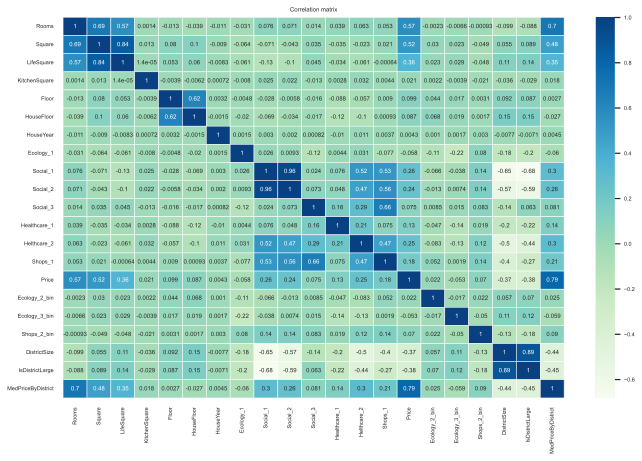

In [681]:
plt.figure(figsize = (10,7))

sns.set(font_scale=0.5)
sns.heatmap(train_df.corr(), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

Очень скоррелированы следующие пары признаков:

*  'Rooms', 'Square'
*  'Floor',  'HouseFloor'
*  'Social_1', 'Social_2'
*  'DistrictSize', 'IsDistrictLarge'
*  'MedPriceByDistrict', 'Dist_sqr_price'


самый значительный 0,96 показатель корреляции по 'Social_1' и "Social_2". Убираю Social_2, DistrictSize

In [682]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 'DistrictSize',
 'IsDistrictLarge',
 'MedPriceByDistrict']

In [683]:
feature_names = [
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_bin',
 'Ecology_3_bin',
 'Shops_2_bin',
 ]

new_feature_names = [
 'IsDistrictLarge',
 'MedPriceByDistrict']

target_name = 'Price'

Разбиение на train и test

In [684]:
X = train_df[feature_names + new_feature_names]
y = train_df[target_name]

In [685]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, shuffle=True)

Построение модели

In [686]:
rf_model = RandomForestRegressor(random_state= 42)

Обучение модели

In [687]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Предсказание и вывод результатов на датафрейме train_df

Train R2:	0.965
Test R2:	0.733


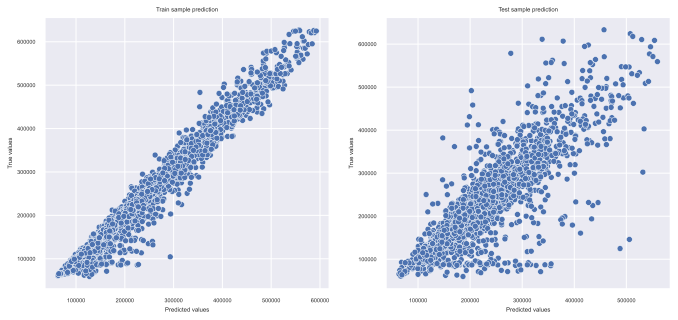

In [688]:
y_train_preds = rf_model.predict(X_train)
y_test_preds =rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)

Перекрестная проверка

In [589]:
cv_score = cross_val_score(rf_model, X, y, scoring = 'r2', cv = KFold(n_splits=3, shuffle = True, random_state = 42) )
cv_score

array([0.73267867, 0.73632493, 0.77366586])

In [689]:
cv_score.mean()

0.7475564875034176

Важность признаков

In [690]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_),
                                   columns = ['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
17,MedPriceByDistrict,0.629639
1,Square,0.128676
2,LifeSquare,0.032881
9,Social_3,0.028908
6,HouseYear,0.028285
3,KitchenSquare,0.027594
8,Social_1,0.022455
4,Floor,0.022063
5,HouseFloor,0.019335
7,Ecology_1,0.017299


Прогнозирование на на датафрейме test_df

In [691]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,900.0,0,0,B,1,1,1,91,0,166809.665642
1,15856,74,2.0,69.263183,54.300483,3.0,1,1.0,1977,0.075779,...,900.0,0,2,B,1,1,1,61,0,243031.695525
2,5480,190,1.0,13.597819,3.077756,12.0,2,5.0,1909,0.000000,...,4702.0,5,5,B,1,1,1,2,0,NaN
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,900.0,3,3,B,1,1,1,49,0,222227.584211
4,14275,27,1.0,47.527111,43.387569,3.0,17,17.0,2017,0.072158,...,900.0,0,0,A,1,1,0,391,1,118327.090620


In [696]:
test_df['MedPriceByDistrict'].median()

197049.2310782437

Заполняю пропуски MedPriceByDistrict

In [698]:
test_df.loc[test_df['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test_df['MedPriceByDistrict'].median()

In [702]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   object 
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          5000 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        5000 non-null   float64
 16  Helthc

In [704]:
test_df.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_bin,Ecology_3_bin,Shops_2_bin,DistrictSize,IsDistrictLarge,MedPriceByDistrict
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,1.906200,56.449500,36.441873,6.655000,7.529600,12.915400,1984.392600,0.119874,24.933800,5406.900000,8.262600,1029.396400,1.31940,4.242800,0.990400,0.970200,0.917600,115.537200,0.325000,211006.725316
std,0.805935,19.092787,17.279606,9.640921,5.167636,6.468617,18.573149,0.120070,17.532202,4026.614773,23.863762,766.595258,1.47994,4.777365,0.097518,0.170052,0.275001,127.381882,0.468422,72434.244811
min,1.000000,1.378543,-10.636656,3.000000,1.000000,1.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,84250.557673
25%,1.000000,41.906231,23.633119,3.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,810.000000,0.00000,1.000000,1.000000,1.000000,1.000000,27.000000,0.000000,165700.355193
50%,2.000000,52.921340,33.137030,6.000000,6.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000,1.000000,1.000000,1.000000,49.000000,0.000000,197049.231078
75%,2.000000,66.285129,46.399457,9.000000,11.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,990.000000,2.00000,6.000000,1.000000,1.000000,1.000000,257.000000,1.000000,239606.501593
max,5.000000,223.453689,148.363201,620.000000,46.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000,1.000000,1.000000,1.000000,391.000000,1.000000,593618.746096


In [710]:
X = train_df[feature_names + new_feature_names]

In [711]:
y_test_preds = rf_model.predict(X_test)

Сохраняем результаты

In [712]:
test_df['Price'] = y_test_preds

In [713]:
test_df.to_csv('KGanskaia_predictions.csv', columns=['Id', 'Price'], index=False, encoding='utf-8')